In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

from functools import partial
import itertools as it

import pandas as pd
import numpy as np
import datetime as dt
import os, sys

from pathlib import Path

import torch
import ray
from ray import train, tune

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm
from wrapt_timeout_decorator import timeout

from src.datasets import daocensus_text
from src.utils import Timer
from src.utils import notebooks as nbutils
from src import paths

%load_ext autoreload
%autoreload 2

### Parameters

In [29]:
JOBLIB_CACHE_DIR = './.cache/11_pln-tune'

TRANSFORMER_MODEL = "all-mpnet-base-v2"
ORG_NAME = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = False

# Evaluation
# N_SPLITS: int = 10
# SKIP_SPLIT: int = 0
K_RECOMMENDATIONS: List[int] = [5, 10]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_SPLITS = 10 # Use just last 10 splits
CUTOFF_DATE_STR: str = dt.datetime.utcnow().isoformat()

MDF_FILE: str = None

# k for K Nearest Neighbors
# KNN_K: int = 1
GRAPHS_METRIC = 'map@10'

In [31]:
CUTOFF_DATE = dt.datetime.fromisoformat(CUTOFF_DATE_STR) if CUTOFF_DATE_STR else None

print('CUTOFF_DATE', CUTOFF_DATE, type(CUTOFF_DATE))
# Metrics Dataframe
MDF_FILE = Path(MDF_FILE) if MDF_FILE else paths.pln_mdf(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

CUTOFF_DATE 2022-07-22 00:00:00 <class 'datetime.datetime'>


In [32]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES, cutoff_date=CUTOFF_DATE)
dfv[['voter', 'proposal']] = dfv[['voter', 'proposal']].astype(str)
dfp[['id']] = dfp[['id']].astype(str)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 2742 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2742 entries, 0 to 2741
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       2742 non-null   object        
 1   name           2742 non-null   object        
 2   id             2742 non-null   object        
 3   proposal       2742 non-null   object        
 4   deployment     2742 non-null   object        
 5   platform_vote  2742 non-null   object        
 6   voter          2742 non-null   object        
 7   date           2742 non-null   datetime64[ns]
 8   choice         2742 non-null   object        
 9   weight         2323 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 235.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, b3c9b57c-5542-5a02-b302-8dd99b1d0a66 to 94bd21d2-f261-5037-a18c-d8121b0975c5
Data columns (total 12

## Getting the embeddings of each proposal

In [33]:
from sentence_transformers import SentenceTransformer
import pickle

str(model)
```
SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)
```

hash(str(model)) = 1078797550815066609

In [40]:
model = SentenceTransformer(TRANSFORMER_MODEL)

In [41]:
from src.models.nlp import get_embeddings_from_cache

model = SentenceTransformer(TRANSFORMER_MODEL)
print(model)
embeddings = get_embeddings_from_cache(dfp, model)

# We have to delete the model because it complains about forking
del model
# ids = embeddings.index
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)
Some embeddings need to be calculated


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [42]:
embeddings_sum = embeddings.sum(axis=0)
print(embeddings.shape, embeddings_sum.shape)
embeddings = embeddings.apply(lambda x: x / embeddings_sum)
embeddings

(793,) (768,)


id
b3c9b57c-5542-5a02-b302-8dd99b1d0a66    [0.0017231037, 0.0018266282, 0.0040534707, 0.0...
9eaa5b0a-c4b2-5eb7-87a2-81b0244287ed    [-0.0020784058, 0.0049672704, 0.005207005, 0.0...
ad952048-0d11-5b43-8f15-cd49e7d530c2    [-0.0060676388, 0.0018290598, 0.0027343587, 0....
0425d70c-b48c-5c3f-88f2-4c5ecde2b055    [-0.003217853, 0.003634009, 0.0017026366, -0.0...
3b1bccad-6ccb-5846-9517-edd861330f21    [-0.004870732, 0.0031257283, 0.00079174066, -0...
                                                              ...                        
8d361e13-2025-5c03-bca3-d556011ad72a    [-0.0015466656, 0.003302328, 0.0015134342, 0.0...
b9e4099d-5228-5276-8890-134bd421ac0f    [0.0019269146, 0.004870786, 0.006161886, 0.003...
ccf70082-0156-56c5-affa-2eb7a55bf60c    [-0.0015466656, 0.003302328, 0.0015134342, 0.0...
010d78ec-be4a-5943-8c02-745904067e45    [0.0010078269, 0.0024531593, 0.0018450749, -0....
94bd21d2-f261-5037-a18c-d8121b0975c5    [0.00040733046, 0.0011549137, 0.0034557702, -0...
Length:

In [9]:
dfp['embeddings'] = embeddings

## Getting the embeddings of each user

The embeddings of each user are the embeddings of each proposal the user has voted in

In [10]:
# dfp['nbidx'] = dfp.index
# _dfv = dfv.merge(dfp[['id', 'nbidx']], how='left', left_on='proposal', right_on='id')
# print('dfp:', dfp.shape, 'dfv:', dfv.shape, '_dfv:', _dfv.shape)
# votes_embeddings = embeddings[_dfv['nbidx']]
votes_embeddings = embeddings.loc[dfv['proposal']]
print('dfp:', dfp.shape, 'dfv:', dfv.shape)
votes_embeddings.shape

dfp: (1943, 13) dfv: (116560, 10)


(116560,)

In [11]:
# observed = True, because voter is categorical and might have no votes really
voter_embeddings = dfv.groupby('voter', observed=True).apply(lambda x: votes_embeddings[x.index].sum(axis=0))
voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
# msk = (np.linalg.norm(np.stack(voter_embeddings.to_numpy()), axis=1) > 0.9)
voter_embeddings

voter
0x0019220ddabe5b8438a6be6ebca31ef01ca69965    [0.0010477987, 0.0015924382, 0.0017050041, 0.0...
0x0023a0bf1cb20362f847dfc977d2c815f6ac8021    [0.009622099, 0.0034187052, 0.003367807, 0.006...
0x0026dd985da16f70e9d9cf739b08c6cdf6a7f407    [0.0015011001, 0.0011227258, 0.00052121805, 0....
0x0029ab135b5be72168bf80f140d60a9264dbd0c5    [0.0018051072, 0.0007161274, 0.0008733617, 0.0...
0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34    [0.0037666145, 0.002783243, 0.002651312, 0.002...
                                                                    ...                        
0xffd92144cafd599a5a93e4805ca4d8f0e666d623    [0.0037441235, 0.003186649, 0.00280605, 0.0035...
0xffd9cd75445459184a4b89a0fbd1720ab2957738    [0.0027223164, 0.003114445, 0.00163464, 0.0030...
0xffe6d9d29480d0673c4fc46da22d21e245c8e731    [0.0056425673, 0.003079375, 0.0010376757, 0.00...
0xffed2f64c9f796d4258618a7a375ed816205821a    [-0.00048470704, 0.0008324865, 0.0009201956, 0...
0xfff28923092a8294456206a6d0734514

In [12]:
dfv.groupby('voter', observed=True).size().sort_values()

voter
0x7dc3331bc545a41e566dfbbb3d8851bf4762486f      1
0x7ae0a65d329bc202e83a360d9afc880063c12337      1
0x7b07608c3e4ef235c7a5e15f02a7fa9552ce113f      1
0x7b29be2f106712287024e6228e015d44cdfa0dec      1
0x7b2ec1a291a0a4dd08d65ab34a62bda1cca618c6      1
                                             ... 
0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8    652
0xd6eff8f07caf3443a1178407d3de4129149d6ef6    727
0xb44ac514588be99870220d12120815bc3d349507    729
0x521b0fef9cdcf250abaf8e7bc798cbe13fa98692    760
0xc54a6c3778016b06cbd126ccc3b5bc06c5f666fb    885
Length: 7268, dtype: int64

## Making recommendations with cosine similarity

Because they are normalized, our ranking score can be just the dot product of a user and a proposal

In [13]:
embeddings_np = np.vstack(embeddings)

In [14]:
# user_emb = voter_embeddings['0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8']
# scores = embeddings_np @ user_emb
# scores.argsort()

In [15]:
def recommend_emb(emb, k, t = None):
    """
    Args:
        emb: The embedding of the item/user to recommend items to
        k (int): The number of items to recommend
        t (timestamp): Simulate that the recommendation is made at time `t`
            i.e: Filter out already closed proposals or not yet open
    """
    # 1D n_proposals
    scores = embeddings_np @ emb

    if t:
        msk = (dfp['start'] < t) & (t < dfp['end'])
        scores[msk] = -np.inf
    
    best = (-scores).argsort()

    dfbest = dfp.iloc[best[:k]].copy()
    dfbest['score'] = scores[best[:k]]
    return dfbest

In [16]:
def recommend_user(voter: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    user_emb = voter_embeddings[voter]
    return recommend_emb(user_emb, k, t)

# recommend_user('0x613e052555ac74ff6af0fc64e40e8035c1e9dcf8')[['title', 'description', 'score']]

In [17]:
def recommend_proposal(proposal: str, k: int = 5, t: Optional[np.datetime64] = None):
    # 1D emb_size
    prop_emb = dfp['embeddings'][proposal]
    return recommend_emb(prop_emb, k, t)

# display(dfp.loc['433b7e43-77b0-5ea1-bac3-0c3071363a56'])
# recommend_proposal('433b7e43-77b0-5ea1-bac3-0c3071363a56')

### Evaluation

First, we will evaluate if the user recommendations are any good using common off-line metrics.

In [18]:
assert not any(voter_embeddings.isna()), "Hay embeddings NA"

In [19]:
np.vstack(voter_embeddings)

array([[ 0.0010478 ,  0.00159244,  0.001705  , ..., -0.00262108,
         0.00302399,  0.00773245],
       [ 0.0096221 ,  0.00341871,  0.00336781, ...,  0.00259694,
        -0.00398165, -0.01983549],
       [ 0.0015011 ,  0.00112273,  0.00052122, ...,  0.00062561,
         0.00074369, -0.00352989],
       ...,
       [ 0.00564257,  0.00307938,  0.00103768, ...,  0.01294672,
         0.00525271,  0.00549167],
       [-0.00048471,  0.00083249,  0.0009202 , ...,  0.0044537 ,
         0.00167882, -0.00284087],
       [ 0.00086909,  0.0006073 ,  0.00085035, ..., -0.00171215,
         0.00043571,  0.00923104]], dtype=float32)

In [20]:
def recommendNLPNaive(train: pd.DataFrame, users, proposals, k: int = 5, remove_training: bool = True, min_score: float = 0):  
    # Create voter embeddings (filtering that they are in train)
    # TODO: Add some kind of discount rate over time
    # TODO: DELETEME
    aux = dfv[dfv['voter'].isin(users) & dfv['proposal'].isin(train['itemID'])]
    not_in_train = set(users).difference(dfv[dfv['proposal'].isin(train['itemID'])]['voter'])
    # print('aux.shape:', aux.shape)
    # print('not in train (in):', len(not_in_train))

    voter_embeddings = aux.groupby('voter', observed=True).apply(lambda x: votes_embeddings[x.index].sum(axis=0))
    voter_embeddings = voter_embeddings.apply(lambda x: x/np.linalg.norm(x))
    # np_voter_embeddings = np.stack(voter_embeddings.to_numpy())
    np_voter_embeddings = np.vstack(voter_embeddings)
    
    # Remove score from proposals not in `proposals`
    msk = embeddings.index.isin(proposals)
    tr_embeddings = np.vstack(embeddings).copy()
    tr_embeddings[~msk] = 0
    
    scores = np_voter_embeddings @ tr_embeddings.T
    
    # Remove score from proposals already voted by user
    if remove_training:
        trainu = train[train['userID'].isin(users)]
        itemID2idx = pd.Series(data=np.arange(len(dfp)), index=dfp.index.astype(str))
        voterID2idx = pd.Series(data=np.arange(len(voter_embeddings)), index=voter_embeddings.index)
        scores[voterID2idx[trainu['userID']], itemID2idx[trainu['itemID']]] = -np.inf
        
    best = (-scores).argsort(axis=1)
    topk = best[:, :k]
    
    # create df with columns
    # userID, itemID, prediction
    uid = np.repeat(np.arange(np_voter_embeddings.shape[0]), k)
    iid = topk.flatten()
    
    # transform int to id
    df = pd.DataFrame({
        'userID': voter_embeddings.index[uid],
        'itemID': dfp.index[iid].astype(str),
        # 'prediction': 1,
        'prediction': scores[uid, iid],
    })
    return df[df['prediction'] > min_score].reset_index(drop=True)

# train = train_filtered
# users = test_filtered['userID'].unique()
# proposals = test_filtered['itemID'].unique()
# k = 3
# remove_training = True

In [21]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from src.datasets import to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent

In [22]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

### Evaluation in multiple months

In [23]:
df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'))[-LAST_SPLITS:]
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

def testHParamsSimilarity(fold, window_size):
    metrics = dict()

    train, test, t, open_proposals = folds[fold]
    offset = pd.tseries.frequencies.to_offset(window_size)

    train_filtered = train[train['timestamp'] > (t - offset)]
    not_in_train = set(test['userID']).difference(train['userID'])
    # print('not in train:', len(not_in_train))
    # print('not in train filtered:', len(not_in_train))
    for k_recs in K_RECOMMENDATIONS:
        with Timer() as t:
            recs = recommendNLPNaive(train_filtered, test['userID'].unique(), open_proposals, k_recs)

        metrics[f'time@{k_recs}'] = t.time
        for m, f in metrics_f.items():
            metrics[m+f'@{k_recs}'] = f(test, recs, k=k_recs)

    return metrics

testHParamsSimilarity(0, '14d')
testHParamsSimilarity(1, '2W')

{'time@5': 0.04025654494762421,
 'precision@5': 0.32244897959183677,
 'ndcg@5': 0.41754244844097116,
 'map@5': 0.2336587905434786,
 'time@10': 0.039528707042336464,
 'precision@10': 0.2789115646258503,
 'ndcg@10': 0.49648541948904495,
 'map@10': 0.319728133386384}

In [24]:
from sklearn.model_selection import ParameterGrid

param_grid = ParameterGrid({
    'fold': range(len(folds)),
    'window_size': ['7d', '14d', '30d', '90d', '180d', '360d', '10Y'],
})

results = list()
for p in tqdm(param_grid):
    results.append(testHParamsSimilarity(**p) | p)

mdf = pd.DataFrame(results).set_index(['fold', 'window_size'])
mdf

100%|███████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


time@5  precision@5    ndcg@5     map@5   time@10  \
fold window_size                                                        
0    7d           0.037780     0.307692  0.677264  0.575874  0.033091   
     14d          0.037581     0.335385  0.711873  0.621285  0.037315   
     30d          0.042873     0.316923  0.666032  0.578733  0.042672   
     90d          0.051772     0.295385  0.641433  0.565650  0.054776   
     180d         0.063406     0.287692  0.628058  0.548477  0.065641   
...                    ...          ...       ...       ...       ...   
9    30d          0.039523     0.273759  0.598138  0.475326  0.048151   
     90d          0.039035     0.250000  0.519065  0.400859  0.050638   
     180d         0.052790     0.221429  0.463694  0.351438  0.056735   
     360d         0.067699     0.214184  0.443070  0.336515  0.074397   
     10Y          0.075805     0.212766  0.416806  0.310212  0.083548   

                  precision@10   ndcg@10    map@10  
fold window_size                                    
0    7d               0.216154  0.753695  0.645062  
     14d              0.213846  0.750625  0.664721  
     30d              0.209231  0.715713  0.625070  
     90d              0.205385  0.706828  0.618423  
     180d             0.200000  0.692730  0.598643  
...                        ...       ...       ...  
9    30d              0.185106  0.643413  0.516595  
     90d              0.181429  0.583986  0.451085  
     180d             0.167857  0.528678  0.399566  
     360d             0.160993  0.502920  0.380409  
     10Y              0.153191  0.470651  0.349726  

[70 rows x 8 columns]

<Axes: xlabel='fold', ylabel='precision@5'>

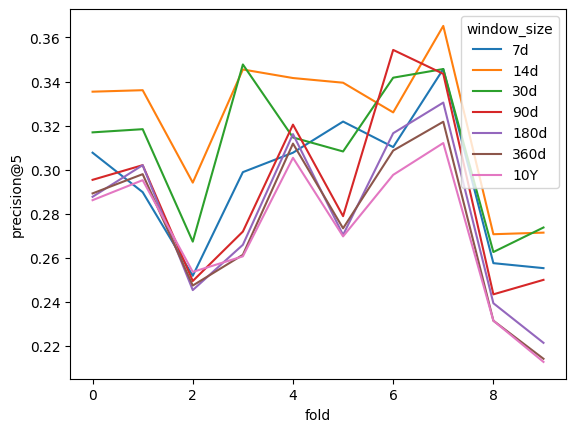

In [25]:
sns.lineplot(mdf, x='fold', y='precision@5', hue='window_size')

In [26]:
mdf.groupby('window_size').describe().drop(columns=['time@10', 'ndcg@10']).T

window_size               10Y        14d       180d        30d       360d  \
time@5       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.081698   0.034850   0.059619   0.038584   0.071855   
             std     0.005451   0.003576   0.004279   0.003559   0.004968   
             min     0.075805   0.031210   0.052790   0.033435   0.065733   
             25%     0.077760   0.032204   0.057115   0.035946   0.068189   
             50%     0.080397   0.033340   0.059750   0.037956   0.070621   
             75%     0.083669   0.036928   0.062698   0.042035   0.073940   
             max     0.093588   0.041470   0.066680   0.043663   0.081211   
precision@5  count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.272474   0.322537   0.279530   0.309700   0.275726   
             std     0.032896   0.032423   0.036964   0.032006   0.036424   
             min     0.212766   0.270707   0.221429   0.262626   0.214184   
             25%     0.255375   0.302084   0.250498   0.282383   0.250908   
             50%     0.277939   0.335720   0.279031   0.315765   0.281313   
             75%     0.297038   0.341042   0.312607   0.335891   0.305986   
             max     0.312088   0.365217   0.330435   0.347727   0.321739   
ndcg@5       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.458658   0.599916   0.479677   0.556042   0.467848   
             std     0.097225   0.098421   0.103111   0.107094   0.100632   
             min     0.356672   0.448304   0.374584   0.415286   0.360972   
             25%     0.381409   0.545807   0.401976   0.484915   0.387111   
             50%     0.428062   0.584547   0.452945   0.508449   0.433835   
             75%     0.526499   0.665531   0.558443   0.649058   0.545273   
             max     0.614903   0.770386   0.644778   0.720778   0.625689   
map@5        count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.347681   0.475615   0.365457   0.435068   0.356537   
             std     0.116367   0.125824   0.122311   0.129867   0.118954   
             min     0.195649   0.261915   0.208014   0.235082   0.200218   
             25%     0.276412   0.407905   0.282146   0.352086   0.283848   
             50%     0.314640   0.459160   0.331446   0.395252   0.320964   
             75%     0.423265   0.549955   0.451963   0.552881   0.438842   
             max     0.532992   0.690269   0.558769   0.633041   0.543986   
precision@10 count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.195118   0.220855   0.201693   0.216568   0.198480   
             std     0.026843   0.028875   0.024860   0.025835   0.025320   
             min     0.153191   0.187857   0.164773   0.185106   0.159091   
             25%     0.183111   0.206440   0.187091   0.201630   0.185038   
             50%     0.197845   0.211271   0.202717   0.211702   0.202076   
             75%     0.206711   0.222368   0.214715   0.225600   0.211016   
             max     0.244898   0.291156   0.244218   0.275510   0.238776   
map@10       count  10.000000  10.000000  10.000000  10.000000  10.000000   
             mean    0.400634   0.529367   0.420295   0.491717   0.410567   
             std     0.113013   0.112951   0.120189   0.120381   0.117421   
             min     0.268910   0.353385   0.274256   0.318340   0.265625   
             25%     0.328330   0.457654   0.352846   0.411649   0.335887   
             50%     0.356569   0.512852   0.375021   0.452991   0.371118   
             75%     0.479161   0.595768   0.506796   0.597951   0.492893   
             max     0.582670   0.727703   0.613936   0.680481   0.595367   

window_size                7d        90d  
time@5       count  10.000000  10.000000  
             mean    0.032516   0.048376  
             std     0.004256   0.004130  
             min     0.027896   0.039035  
           

In [28]:
from src import baseline

# bdf = pd.read_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))[-LAST_SPLITS:]
bdf = baseline.read_metrics_baseline(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)[-LAST_SPLITS:]
assert bdf.index.max() < CUTOFF_DATE if CUTOFF_DATE else True
bdf['fold'] = np.arange(10)
bdf.describe()

Index(['2021-05-26 23:49:47', '2021-06-02 23:53:44', '2021-06-09 22:27:35',
       '2021-06-16 22:05:04', '2021-06-23 22:35:57', '2021-06-30 23:47:53',
       '2021-07-07 23:51:57', '2021-07-14 22:53:59', '2021-07-21 18:12:44',
       '2021-07-28 22:21:39',
       ...
       '2023-05-10 22:56:17', '2023-05-17 23:19:42', '2023-05-24 23:50:20',
       '2023-05-31 23:57:12', '2023-06-07 22:58:08', '2023-06-14 22:25:09',
       '2023-06-21 23:50:36', '2023-06-28 21:57:25', '2023-07-05 23:49:06',
       '2023-07-12 23:35:49'],
      dtype='object', name='t', length=112)


TypeError: '<=' not supported between instances of 'str' and 'datetime.datetime'

In [ ]:
# pdf = pd.read_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))[-LAST_SPLITS:]
pdf = baseline.read_metrics_perfect(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, cutoff_date=CUTOFF_DATE)[-LAST_SPLITS:]
pdf['fold'] = np.arange(10)
pdf.describe()

In [ ]:
_METRICS = ['map@5', 'map@10']
_METRIC = _METRICS[-1]

ax = sns.lineplot(mdf, x='fold', y=_METRIC, hue='window_size')
ax = sns.lineplot(bdf, x='fold', y=_METRIC, color='red', zorder=0)
ax.lines[-1].set_linestyle('--')
ax.text(9, 0.19, "MP Baseline", ha='right', color=ax.lines[-1].get_color())

# ax = sns.lineplot(pdf, x='fold', y=_METRIC, color='blue')
# ax.lines[-1].set_linestyle(':')

ax.set_ylim((0,None));
nbutils.download_matplotlib(ax.figure, f'11_cosine_results_results-lines_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

In [ ]:
# _METRIC = 'precision@5'

topline = pdf[_METRIC].mean()

_toplot = mdf[_METRICS].melt(value_vars=_METRICS, var_name='metric', ignore_index=False)

sns.set_theme()
ax = sns.barplot(_toplot, x='window_size', y='value', hue='metric')
ax.set_xlabel("Window size")

baseline = bdf[_METRICS[0]].mean()
ax.axhline(baseline, ls='--', color='blue', zorder=0)
baseline = bdf[_METRICS[1]].mean()
ax.axhline(baseline, ls='--', color='orange', zorder=0)
# ax.text(0, baseline-0.005, "map@5", color='black', ha='left', va='top', fontsize='large')

if not _METRIC.startswith('map@'):
    ax.axhline(topline, ls=':', color='blue')
    ax.text(0, topline-0.005, "perfect", color='blue', ha='left', va='top')

ax2 = ax.twinx()
time_color = 'green'
sns.lineplot(mdf, x='window_size', y='time@10', color=time_color, ax=ax2, markers=True, dashes=(4,2), errorbar=None)
ax2.set_ylabel('time (s)', color=time_color)
ax2.tick_params(axis='y', color=time_color)
ax2.spines['right'].set_color(time_color)
[t.set_color(time_color) for t in ax2.yaxis.get_ticklabels()]
ax2.grid(False)
ax2.set_ylim((0,.10))

ax.legend(loc=(0.02,.2))

print(type(plt.figure()))
nbutils.download_matplotlib(ax.figure, f'11_cosine_results_window-size_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

# Second iteration: PLN with kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# itemID2idx = pd.Series(data=np.arange(len(dfp)), index=dfp.index.astype(str))
# itemID2idx

In [ ]:
def filter_proposals_in_train(train, user, proposals):
    msk = train['userID'] == user
    proposals_aready_voted_by_user = train[msk]['itemID'].unique()
    return np.setdiff1d(proposals, proposals_aready_voted_by_user)

In [ ]:
from joblib import Memory

# memory = Memory(JOBLIB_CACHE_DIR, mmap_mode='c', verbose=0)

# @memory.cache
def recommendUserKNN(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, knn_k = 3, do_sampling: Optional[bool] = None, remove_train: bool = True, metric=None):
    """
    Given the train data (proposals that might be voted or not by the user), recommend k proposals from proposals to the user
    The train data is a DataFrame in microsoft's format
    
    do_sampling (bool) : default None
        if True, makes sampling so the number of positive and negative samples is the same
        if False, doesn't do it
        if None (default), does it when k > 0, but doesn't do it with Nearest Neighbor
    """
    # train['hasVoted'] = train['userID'] == user
    hasVoted = train['userID'] == user

    # Remove recommendations already in training
    # (aka remove from proposals array)
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)

    assert any(hasVoted), 'The user has not voted in any proposal'
    if knn_k == 0:
        do_sampling = False
        knn_k = 1

    if do_sampling or (do_sampling is None and knn_k > 0):
        # num_samples = train['hasVoted'].value_counts().min() # [True]
        num_samples = hasVoted.value_counts().min() # [True]
        train = train.groupby(hasVoted).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
        hasVoted = train['userID'] == user

    # known_embeds = embeddings[itemID2idx[train['itemID']]]
    known_embeds = np.vstack(embeddings.loc[train['itemID']])

    assert knn_k >= 0
    knn = KNeighborsClassifier(max(knn_k, 1), metric=metric if metric else 'minkowski')
    knn.fit(known_embeds, hasVoted)# train['hasVoted'])

    predict_embeds = np.vstack(embeddings.loc[proposals])
    aux = knn.predict_proba(predict_embeds)
    p = knn.predict_proba(predict_embeds)[:, 1] # Probabilidad de que sea True

    if top_k:
        best = (1-p).argsort()[:top_k]
        p = p[best]
        proposals = proposals[best]
    
    return pd.DataFrame({
        'userID': user,
        'itemID': proposals,
        'prediction': 1,
        'score': p,
    })

# u = '0xe44782afe398800d7190796018c4b865e32ff806'
# proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
# print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
# p = recommendUserKNN(train, u, test_filtered['itemID'].unique().copy(), 5, do_sampling=True)
# p['correct'] = p['itemID'].isin(proposals_voted_by_user['itemID'])
# p

In [ ]:
from recommenders.datasets.pandas_df_utils import filter_by

def recommendMostVoted(train: pd.DataFrame, user, proposals, top_k: Optional[int] = None, remove_train=True):
    bestVotes = train[train['itemID'].isin(proposals)]['itemID'].value_counts()
    df = pd.DataFrame({
        'userID': user,
        'itemID': bestVotes.index,
        'prediction': 1,
        'score': bestVotes,
    })
    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
    return df.head(top_k).reset_index(drop=True)

# u = '0xe44782afe398800d7190796018c4b865e32ff806'
# proposals_voted_by_user = test_filtered[test_filtered['userID'] == u]
# print(f'The user {u} voted in {len(proposals_voted_by_user)} proposals')
# recommendMostVoted(train_filtered.copy(), u, test_filtered['itemID'].unique(), 5)

In [ ]:
# import multiprocessing as mp
# from multiprocessing import Pool
# from multiprocessing.pool import ThreadPool as Pool

from joblib import Parallel, delayed

def recommendUserKNNwithFallback(train, user, proposals, top_k = None, knn_k: int = 1, remove_train: bool = True, do_sampling = None, metric=None):
    """ If the user has not voted in any proposal in `train`, we fall back to recommending
    the most voted proposal in `proposals`
    """
    if remove_train:
        proposals = filter_proposals_in_train(train, user, proposals)
    if (user == train['userID']).sum() >= max(knn_k, 1):
        df = recommendUserKNN(train, user, proposals, top_k, knn_k, remove_train=False, do_sampling=do_sampling, metric=metric)
        df['scoreType'] = 'knn'
        return df
    else:
        df = recommendMostVoted(train, user, proposals, top_k, remove_train=False)
        df['scoreType'] = 'mv'
        return df

def recommendNLPKNN(train: pd.DataFrame, users, proposals, top_k: int = 5, knn_k: int = 1, do_sampling=None, cpus=-1, chunksize=8, disable_tqdm=False, metric=None):
    # Create voter embeddings
    assert knn_k >= 0

    # return pd.concat(tqdm((
    #     recommendUserKNNwithFallback(train, u, proposals, top_k, knn_k, remove_train=False, do_sampling=do_sampling) for u in users
    # ), desc='users', leave=False, total=len(users)))

    p = partial(
        recommendUserKNNwithFallback, 
        train, 
        proposals=proposals, 
        top_k=top_k,
        knn_k=knn_k,
        do_sampling=do_sampling,
        metric=metric,
    )

    if cpus == 1:
        # return pd.concat(tqdm(
        return pd.concat(
            map(p, users),
            # total=len(users),
            # desc='users',
            # leave=False,
            # disable=disable_tqdm,
        )
        # ))
    else:
        # with Pool(mp.cpu_count() // 4 if cpus==-1 else cpus) as pool:
        #     return pd.concat(
        #         tqdm(
        #             pool.imap(p, users, chunksize=chunksize),
        #             total=len(users),
        #             desc='users',
        #             leave=False,
        #             disable=disable_tqdm,
        #         )
        #     )
        return pd.concat(
            Parallel()(delayed(p)(u) for u in tqdm(users, desc='users', leave=False, disable=disable_tqdm))
        )

recommendNLPKNN(folds[0][0], folds[0][1]['userID'].unique(), folds[0][1]['itemID'].unique(), top_k=1)

In [ ]:
# print(mp.cpu_count())

### Evaluation

Usaremos el método del codo para ver cual de todos es mejor

In [ ]:
df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', return_open=True))[-LAST_SPLITS:]
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

def testHParamsKNN(fold, window_size, k, metric, cpus=-1, disable_tqdm=True):
    metrics = dict()

    train, test, t, open_proposals = folds[fold]
    offset = pd.tseries.frequencies.to_offset(window_size)
    train_filtered = train[train['timestamp'] > (t - offset)]

    for k_recs in K_RECOMMENDATIONS:
        with Timer() as t:
            recs = recommendNLPKNN(train_filtered, test['userID'].unique(), open_proposals, k_recs, k, disable_tqdm=disable_tqdm, metric=metric, cpus=cpus)

        metrics[f'time@{k_recs}'] = t.time
        metrics[f'knnUsage@{k_recs}'] = (recs['scoreType'] == 'knn').mean()
        for m, f in metrics_f.items():
                metrics[m+f'@{k_recs}'] = f(test, recs, k=k_recs)

    return metrics

metrics = testHParamsKNN(0, '14d', 0, 'cosine')
metrics

In [ ]:
from sklearn.model_selection import ParameterGrid
from tqdm.contrib.concurrent import thread_map as tqdm_map
# from joblib import Memory

# memory = Memory('.cache')

param_grid = ParameterGrid({
    'fold': range(len(folds)),
    'window_size': ['7d', '14d', '30d', '90d', '180d', '360d', '10Y'],
    'k': [1,2,3,4,5,6,7,8,9,10,15,20,30,50],
    'metric': ['minkowski', 'cosine'],
})

# @memory.cache
def retDict(p):
    # @timeout(90, use_signals=True, exception_message=f"Timeout testing {p}")
    def aux(p):
        return testHParamsKNN(cpus=1, **p) | p

    return aux(p)

# TODO: Open the pickle file and do only the ones missing

if not MDF_FILE.exists():
    results = tqdm_map(retDict, param_grid, chunksize=4, tqdm_class=tqdm, max_workers=8)
    # results = map(retDict, tqdm(param_grid))
    mdf = pd.DataFrame(results).set_index(['fold', 'window_size', 'k', 'metric'])
    mdf.to_pickle(MDF_FILE)
else:
    mdf = pd.read_pickle(MDF_FILE)
mdf

In [ ]:
KNN_ANALYZE_METRIC = 'map@10'

In [ ]:
mdf_mean = mdf.groupby(['k', 'window_size', 'metric']).mean()
mdf_mean.sort_values(KNN_ANALYZE_METRIC)

### Plotting

In [ ]:
cols = [KNN_ANALYZE_METRIC, 'map@5', 'time@10']

(mdf
 .groupby(['window_size', 'k', 'metric'])[cols]
 .describe()
 .sort_values((KNN_ANALYZE_METRIC, 'mean'), ascending=False)
 .loc[:, (slice(None), ['mean', 'std'])]
 .head(10)
)

In [ ]:
import matplotlib.ticker as mtick

ax = (mdf.groupby('k')[['knnUsage@5', 'knnUsage@10']].mean()*100).plot(style='.-')
ax.set_ylim((0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
nbutils.download_matplotlib(ax.figure, f'11_knn_usage_k_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

In [ ]:
order = param_grid.param_grid[0]['window_size']
_toplot = (mdf.groupby('window_size')[['knnUsage@5', 'knnUsage@10']].mean()*100).loc[order]

ax = _toplot.plot(style='.-')
ax.set_ylim((0, 100))
ax.set_xlabel('Tamaño de ventana')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
nbutils.download_matplotlib(ax.figure, f'11_knn_usage_window_size_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

In [ ]:
_toplot = mdf_mean.reset_index().copy()
_toplot['days'] = pd.to_timedelta(_toplot['window_size']).dt.days
_toplot = _toplot.sort_values(['k', 'days'])
# _toplot['color'] = _toplot['window_size'] + ',' + _toplot['metric']

fig = px.line(
    _toplot, 
    x='k', 
    y=KNN_ANALYZE_METRIC, 
    color='window_size', 
    markers=True, 
    line_dash='metric', 
    hover_data='time@10',
    # color_discrete_sequence=px.colors.sequential.Turbo,
)
display(nbutils.download_plotly(fig, f'11_knn_results_k-size_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf'))
fig

In [ ]:
baseline = baseline = bdf[KNN_ANALYZE_METRIC].mean()

ax = sns.lineplot(_toplot, 
    x='k', 
    y=KNN_ANALYZE_METRIC, 
    hue='window_size', 
    # markers=True, 
    style='metric', 
    # hover_data='time@10',
)
ax.axhline(baseline, linestyle=':')
ax.text(0, baseline, "baseline", 
        color=ax.lines[-1].get_color(),
        ha='left', 
        va='bottom',
        fontsize='large',
)
# ax.set_xlabel('log')
# ax.set_ylim((0,0.7))
nbutils.download_matplotlib(ax.figure, f'11_knn_results_all_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

In [ ]:
baseline = baseline = bdf[KNN_ANALYZE_METRIC].mean()

ax = sns.lineplot(_toplot, 
    x='k', 
    y='time@10', 
    hue='window_size', 
    # markers=True, 
    style='metric', 
    # hover_data='time@10',
)
# ax.set_xscale('log')
ax.set_ylabel('time (s)')
nbutils.download_matplotlib(ax.figure, f'11_knn_results_time_{SPLITS_FREQ}_normalize={SPLITS_NORMALIZE}.pdf')

In [ ]:
_toplot = mdf.groupby(['window_size', 'metric']).mean().reset_index()
_toplot['days'] = pd.to_timedelta(_toplot['window_size']).dt.days
_toplot = _toplot.sort_values('days')

px.bar(
    _toplot,
    x='window_size',
    y=KNN_ANALYZE_METRIC,
    color='metric',
    hover_data='time@10',
    # pattern_shape='metric',
    barmode='group',
)